# 19.04 Interpreting Estimated Coefficients
## Assignment 03 House Prices Model

In this exercise, you'll interpret your house prices model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Run your house prices model again and interpret the results. Which features are statistically significant, and which are not?
* Now, exclude the insignificant features from your model. Did anything change?
* Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?
* Do the results sound reasonable to you? If not, try to explain the potential reasons.

### Load the houseprices Data

In [1]:
import warnings

import numpy as np 
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import linear_model
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 
import scipy.stats as stats 
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats.stats import pearsonr
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import percentileofscore # Ref 17.10 challenge
from scipy.stats.mstats import winsorize # Ref 17.10 challenge
from statsmodels.tsa.stattools import acf

warnings.filterwarnings(action="ignore")

kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "houseprices"
)

In [2]:
# Use the IQR Method to establish a threshold for outliers
def run_iqr_method(df):
    continuous_cols = df.iloc[:,1:].select_dtypes(exclude=['object','category','datetime64[ns]']).columns
    for col in continuous_cols: 
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25

        print(f"Variable: {col}")
        for threshold in np.arange(1,5,0.5): 
            min_val = q25 - (iqr*threshold)
            max_val = q75 + (iqr*threshold)
            outliers = len((np.where((df[col] > max_val) 
                        | (df[col] < min_val))[0]))

            pcnt_min = percentileofscore(df[col], min_val)
            pcnt_max = percentileofscore(df[col], max_val)
            # if outliers == 0: 
            print(f"\tIQR Threshold: {threshold:>{4}.1f} | Outliers: {outliers} |"\
                f" {pcnt_min:.2f},"\
                f" {pcnt_max:.2f}")
                # break
        print(100*"=")

In [3]:
def winsorized_comparison(df, col, tup):
    """Take in a dataframe, a column name, and a tuple for the min and max winsorize values.  Then plot the dataframe to see if he outliers have been eliminated."""
    
    plt.figure(figsize=(18,6))
    
    plt.subplot(1,2,1)
    plt.boxplot(df[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of unwinsorized {col}")

    plt.subplot(1,2,2)
    winsorized = winsorize(df[col], tup)
    plt.boxplot(winsorized)
    plt.xticks([1], [f"{col} (winsorized)"])
    plt.title(f"Box Plot of winsorized {col}")

    plt.suptitle(f"Unwinsorized and Winsorized box plots of {col}")
    plt.show()

    q75, q25 = np.percentile(winsorized, [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outliers = len((np.where((winsorized > max_val) 
                | (winsorized < min_val))[0]))

    pcnt_min = percentileofscore(winsorized, min_val)
    pcnt_max = percentileofscore(winsorized, max_val)
    
    display(f"{col} - IQR Threshold: {1.5:>{4}.1f} | Outliers: {outliers}");

In [4]:

# Plot a correlaiton matrix
def corr_plot(corr_mat,figsize):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(f"Correlation matrix of winsorized variables")

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

In [5]:
# Load the data from the "houseprices" database
engine=create_engine(URL(**kagle), echo=True)

houses_raw=pd.read_sql_query("SELECT * FROM houseprices", con=engine)

engine.dispose()

2020-01-05 04:39:33,018 INFO sqlalchemy.engine.base.Engine select version()
2020-01-05 04:39:33,023 INFO sqlalchemy.engine.base.Engine {}
2020-01-05 04:39:33,126 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-01-05 04:39:33,128 INFO sqlalchemy.engine.base.Engine {}
2020-01-05 04:39:33,230 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-05 04:39:33,234 INFO sqlalchemy.engine.base.Engine {}
2020-01-05 04:39:33,292 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-05 04:39:33,294 INFO sqlalchemy.engine.base.Engine {}
2020-01-05 04:39:33,347 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-01-05 04:39:33,348 INFO sqlalchemy.engine.base.Engine {}
2020-01-05 04:39:33,469 INFO sqlalchemy.engine.base.Engine SELECT * FROM houseprices
2020-01-05 04:39:33,472 INFO sqlalchemy.engine.base.Engine {}


In [6]:
houses_working = houses_raw.copy()
houses_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Due to the number of columns, I want to try to remove as many categorical columns as possible.

In [7]:
# To make for clearer printing get the length of the longest column name and that column name
max_length, longest_col_name = max([len(x),x] for x in list(houses_working.columns))

# Print out the number of unique values for each variable to help identify categorical varaibles
for col in houses_raw.columns:
    print(f"{col:<{max_length}}: {len(houses_raw[col].unique()):>{4}}")

id           : 1460
mssubclass   :   15
mszoning     :    5
lotfrontage  :  111
lotarea      : 1073
street       :    2
alley        :    3
lotshape     :    4
landcontour  :    4
utilities    :    2
lotconfig    :    5
landslope    :    3
neighborhood :   25
condition1   :    9
condition2   :    8
bldgtype     :    5
housestyle   :    8
overallqual  :   10
overallcond  :    9
yearbuilt    :  112
yearremodadd :   61
roofstyle    :    6
roofmatl     :    8
exterior1st  :   15
exterior2nd  :   16
masvnrtype   :    5
masvnrarea   :  328
exterqual    :    4
extercond    :    5
foundation   :    6
bsmtqual     :    5
bsmtcond     :    5
bsmtexposure :    5
bsmtfintype1 :    7
bsmtfinsf1   :  637
bsmtfintype2 :    7
bsmtfinsf2   :  144
bsmtunfsf    :  780
totalbsmtsf  :  721
heating      :    6
heatingqc    :    5
centralair   :    2
electrical   :    6
firstflrsf   :  753
secondflrsf  :  417
lowqualfinsf :   24
grlivarea    :  861
bsmtfullbath :    4
bsmthalfbath :    3
fullbath     :    4


In [8]:
# Run Turkey's method function on life_expectancy_df
run_iqr_method(houses_working)

Variable: mssubclass
	IQR Threshold:  1.0 | Outliers: 103 | 0.00, 90.00
	IQR Threshold:  1.5 | Outliers: 103 | 0.00, 92.95
	IQR Threshold:  2.0 | Outliers: 40 | 0.00, 97.26
	IQR Threshold:  2.5 | Outliers: 0 | 0.00, 100.00
	IQR Threshold:  3.0 | Outliers: 0 | 0.00, 100.00
	IQR Threshold:  3.5 | Outliers: 0 | 0.00, 100.00
	IQR Threshold:  4.0 | Outliers: 0 | 0.00, 100.00
	IQR Threshold:  4.5 | Outliers: 0 | 0.00, 100.00
Variable: lotfrontage
	IQR Threshold:  1.0 | Outliers: 0 | nan, nan
	IQR Threshold:  1.5 | Outliers: 0 | nan, nan
	IQR Threshold:  2.0 | Outliers: 0 | nan, nan
	IQR Threshold:  2.5 | Outliers: 0 | nan, nan
	IQR Threshold:  3.0 | Outliers: 0 | nan, nan
	IQR Threshold:  3.5 | Outliers: 0 | nan, nan
	IQR Threshold:  4.0 | Outliers: 0 | nan, nan
	IQR Threshold:  4.5 | Outliers: 0 | nan, nan
Variable: lotarea
	IQR Threshold:  1.0 | Outliers: 184 | 5.27, 92.67
	IQR Threshold:  1.5 | Outliers: 69 | 0.14, 95.41
	IQR Threshold:  2.0 | Outliers: 54 | 0.00, 96.30
	IQR Threshold:  2

In [9]:
# houses_raw.iloc[:,70:80].head(10)

In [10]:
# These are the columns that will be changed to categorical
cat_cols = ["mssubclass","mszoning","street","alley","lotshape","landcontour","utilities","lotconfig","landslope",
            "neighborhood","condition1","condition2","bldgtype","housestyle","overallqual","overallcond",
            "yearremodadd","roofstyle","roofmatl","exterior1st","exterior2nd","masvnrtype","masvnrarea", "exterqual",
            "extercond","foundation","bsmtqual","bsmtcond","bsmtexposure","bsmtfintype1","bsmtfintype2","heating",
            "heatingqc","centralair","electrical","kitchenabvgr","kitchenqual","functional","fireplacequ","garagetype",
            "garagefinish","garagequal","garagecond","paveddrive","poolqc","fence","miscfeature",
            "saletype","salecondition"
           ]

houses_working[cat_cols] = houses_working[cat_cols].astype(dtype="object")

yr_cols = ["yearbuilt","yearremodadd","garageyrblt","mosold","yrsold"]

# These are the columns that will be changed to datetime64[ns]
houses_working[yr_cols] = houses_working[yr_cols].astype(dtype="datetime64[ns]")

In [11]:
# Interpolate missing values for continuous columns
houses_working.groupby(["neighborhood","yearbuilt"]).apply(lambda group: group.interpolate(limit_direction="both"))

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000002008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1970-01-01 00:00:00.000000005,1970-01-01 00:00:00.000002007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000002008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000002006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1970-01-01 00:00:00.000000012,1970-01-01 00:00:00.000002008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1970-01-01 00:00:00.000000008,1970-01-01 00:00:00.000002007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000002010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,1970-01-01 00:00:00.000000005,1970-01-01 00:00:00.000002010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1970-01-01 00:00:00.000000004,1970-01-01 00:00:00.000002010,WD,Normal,142125


In [12]:
houses_working.dropna(axis="columns",inplace=True)
houses_working.drop(columns=["lowqualfinsf","bsmtfinsf2","bsmtfullbath","bsmthalfbath","threessnporch","screenporch","enclosedporch","poolarea",
                             "miscval","secondflrsf","fullbath","halfbath","bedroomabvgr","fireplaces","wooddecksf","openporchsf"],inplace=True)
# houses_working.info()

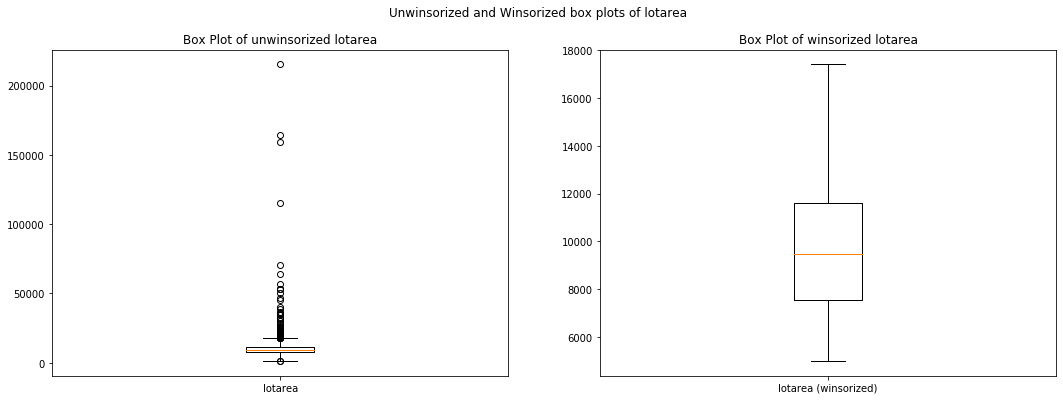

'lotarea - IQR Threshold:  1.5 | Outliers: 0'

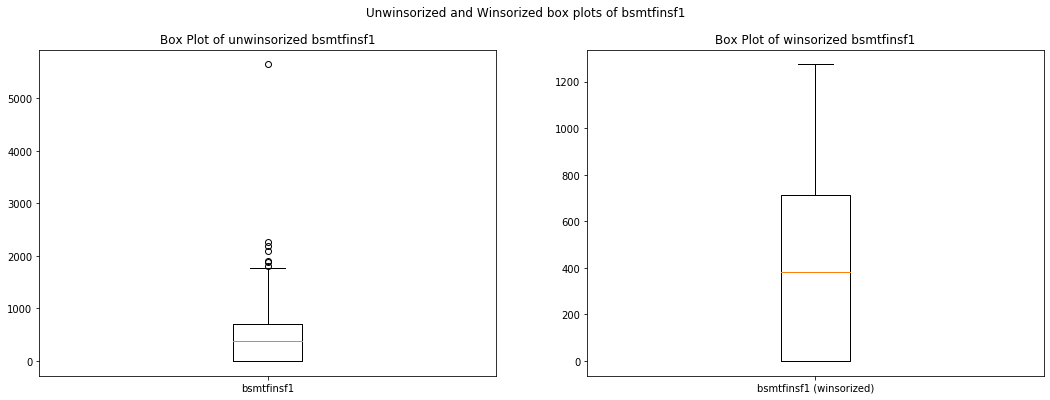

'bsmtfinsf1 - IQR Threshold:  1.5 | Outliers: 0'

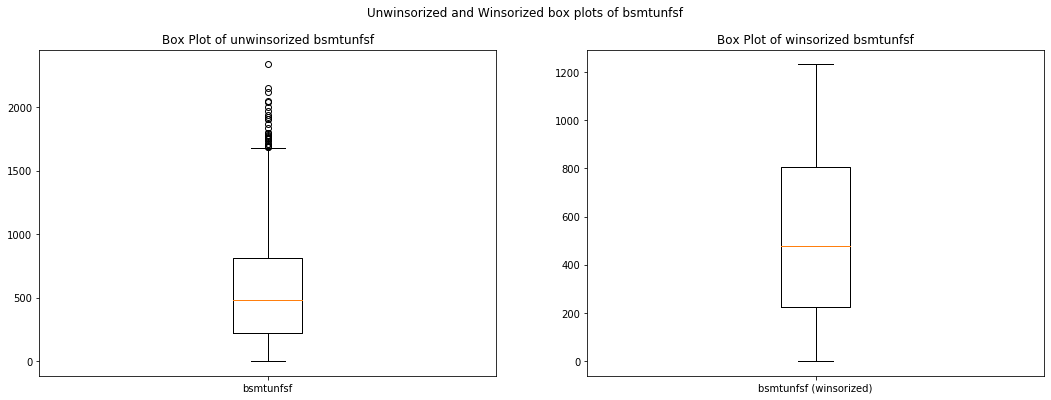

'bsmtunfsf - IQR Threshold:  1.5 | Outliers: 0'

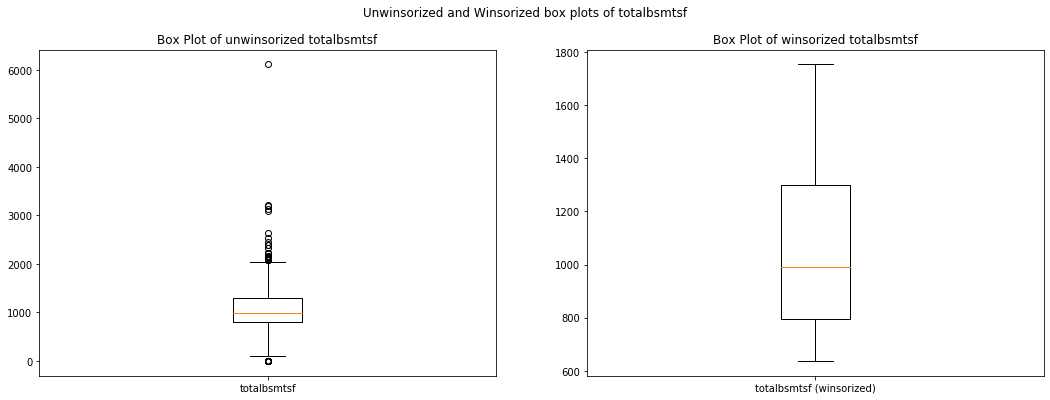

'totalbsmtsf - IQR Threshold:  1.5 | Outliers: 0'

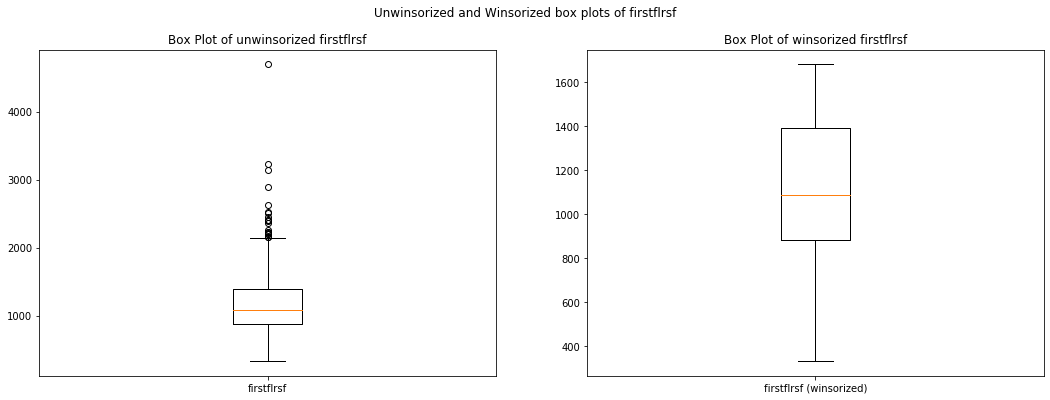

'firstflrsf - IQR Threshold:  1.5 | Outliers: 0'

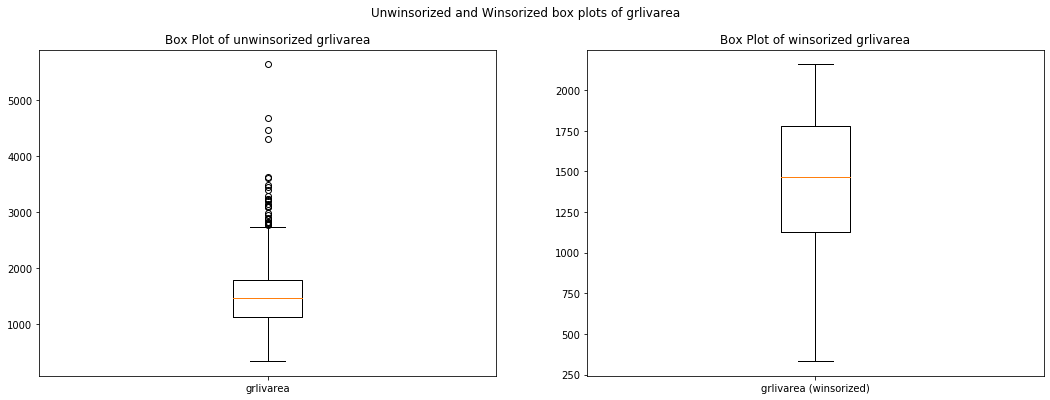

'grlivarea - IQR Threshold:  1.5 | Outliers: 0'

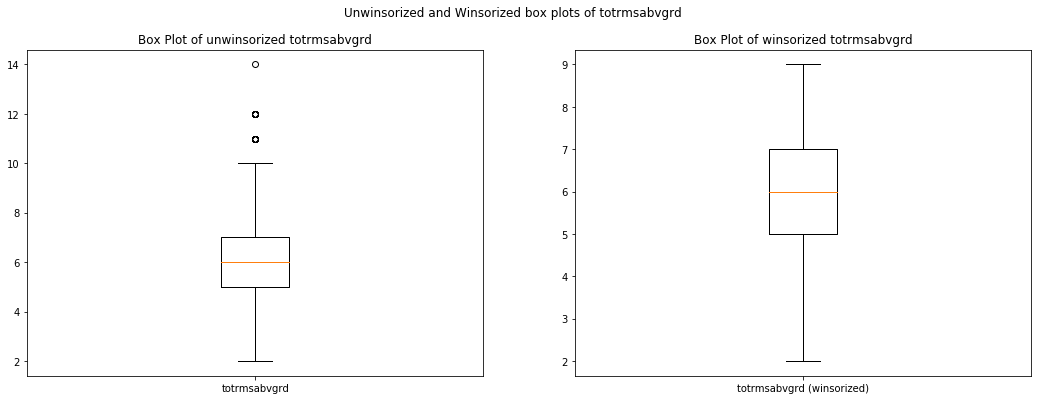

'totrmsabvgrd - IQR Threshold:  1.5 | Outliers: 0'

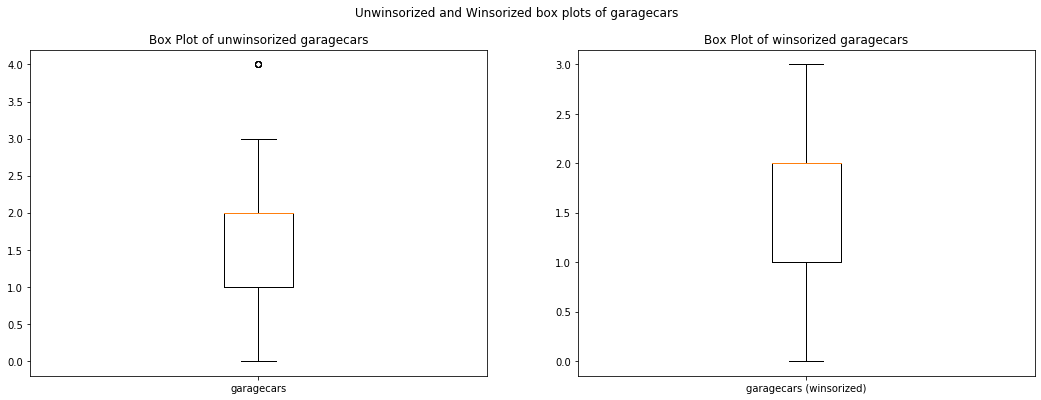

'garagecars - IQR Threshold:  1.5 | Outliers: 0'

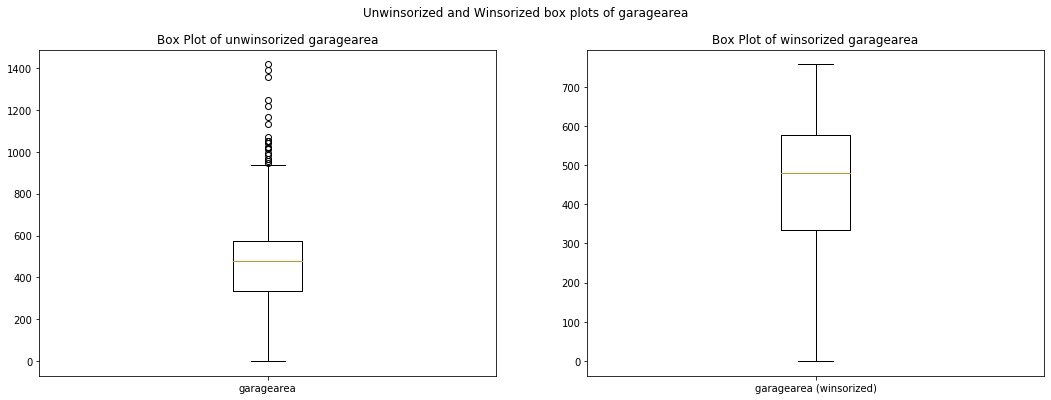

'garagearea - IQR Threshold:  1.5 | Outliers: 0'

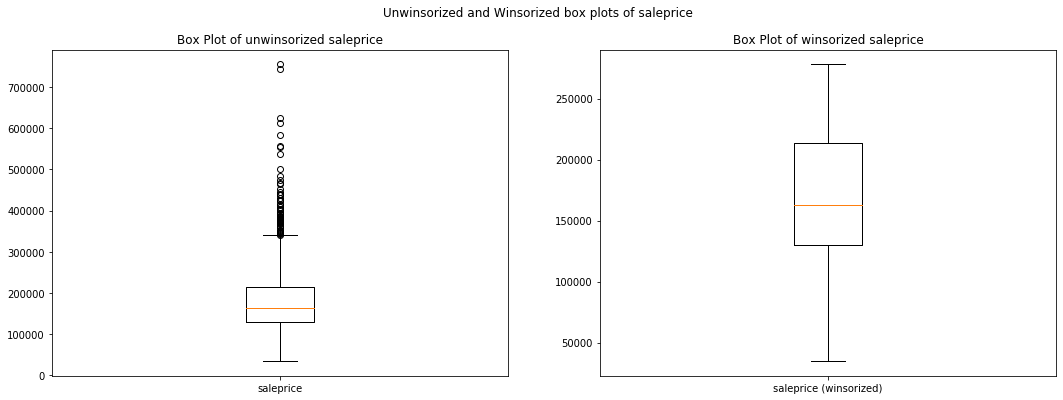

'saleprice - IQR Threshold:  1.5 | Outliers: 0'

In [13]:
winsorize_vals = dict(
   lotarea=(0.10,0.05),
    bsmtfinsf1=(0.0,0.05),
    bsmtunfsf=(0.0,0.1),
    totalbsmtsf=(0.10,0.05),
    firstflrsf=(0.0,0.1),
    grlivarea=(0.0,0.1),
    totrmsabvgrd=(0.0,0.1),
    garagecars=(0.0,0.1),
    garagearea=(0.0,0.1),
    saleprice=(0.0,0.1)
    )

# Plot the winsorized values for comparison sake and see if your missing any outliers 
for i, (k,v) in enumerate(winsorize_vals.items()):
    # print(f"index: {i}, key: {k}, value: {v}")
    winsorized_comparison(houses_raw,k,v)

In [14]:
# Now that the outliers have been eliminated, join winsorized columns to the life_expectancy_df dataframe
houses_winsorized =houses_working.copy()

for i, (k,v) in enumerate(winsorize_vals.items()):
    houses_winsorized[f"{k}_winsorized"] = winsorize(houses_winsorized[k], v)

# take a look at the new dataframe
houses_winsorized.sample(n=10)

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,lotarea_winsorized,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,totalbsmtsf_winsorized,firstflrsf_winsorized,grlivarea_winsorized,totrmsabvgrd_winsorized,garagecars_winsorized,garagearea_winsorized,saleprice_winsorized
386,386,120,RL,3182,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,5000,24,1232,1256,1269,1269,6,2,430,192000
961,962,60,RL,12227,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,12227,896,434,1330,1542,2158,9,2,619,272000
355,355,50,RL,8400,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,8400,388,552,940,1192,1595,6,1,240,140000
135,135,20,RL,10335,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,10335,570,891,1461,1680,1721,7,2,440,180000
905,906,20,RL,9920,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,9920,354,412,1056,1063,1063,6,1,280,128000
1277,1278,80,RL,17871,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,17400,528,1152,1680,1680,1724,7,2,480,197900
170,170,20,RL,16669,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,16669,0,1232,1686,1680,1707,6,2,511,228000
1212,1213,30,RL,9340,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,9340,344,328,672,672,672,4,1,234,113000
85,86,60,RL,16059,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,16059,0,1232,1288,1301,2158,9,2,462,260000
1090,1091,90,RL,8544,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,8544,0,0,637,1040,1040,6,2,400,92900


In [15]:
# discriptive statistics for continuous cols
houses_continuous_described = pd.DataFrame(houses_winsorized.describe())

In [16]:
houses_continuous_described.iloc[:,1:11]

,lotarea,bsmtfinsf1,bsmtunfsf,totalbsmtsf,firstflrsf,grlivarea,totrmsabvgrd,garagecars,garagearea,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,443.639726,567.240411,1057.429452,1162.626712,1515.463699,6.517808,1.767123,472.980137,180921.195890
std,9981.264932,456.098091,441.866955,438.705324,386.587738,525.480383,1.625393,0.747315,213.804841,79442.502883
min,1300.000000,0.000000,0.000000,0.000000,334.000000,334.000000,2.000000,0.000000,0.000000,34900.000000
25%,7553.500000,0.000000,223.000000,795.750000,882.000000,1129.500000,5.000000,1.000000,334.500000,129975.000000
50%,9478.500000,383.500000,477.500000,991.500000,1087.000000,1464.000000,6.000000,2.000000,480.000000,163000.000000
75%,11601.500000,712.250000,808.000000,1298.250000,1391.250000,1776.750000,7.000000,2.000000,576.000000,214000.000000
max,215245.000000,5644.000000,2336.000000,6110.000000,4692.000000,5642.000000,14.000000,4.000000,1418.000000,755000.000000


In [17]:
houses_continuous_described.iloc[:,11:]

,lotarea_winsorized,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,totalbsmtsf_winsorized,firstflrsf_winsorized,grlivarea_winsorized,totrmsabvgrd_winsorized,garagecars_winsorized,garagearea_winsorized,saleprice_winsorized
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,9804.984247,431.089041,539.463014,1064.473973,1137.183562,1471.303425,6.434932,1.763699,461.000685,173020.252055
std,3270.059584,412.214952,380.716698,334.998874,321.845001,416.756054,1.434142,0.739318,189.798423,58293.996886
min,5000.000000,0.000000,0.000000,637.000000,334.000000,334.000000,2.000000,0.000000,0.000000,34900.000000
25%,7553.500000,0.000000,223.000000,795.750000,882.000000,1129.500000,5.000000,1.000000,334.500000,129975.000000
50%,9478.500000,383.500000,477.500000,991.500000,1087.000000,1464.000000,6.000000,2.000000,480.000000,163000.000000
75%,11601.500000,712.250000,808.000000,1298.250000,1391.250000,1776.750000,7.000000,2.000000,576.000000,214000.000000
max,17400.000000,1274.000000,1232.000000,1753.000000,1680.000000,2158.000000,9.000000,3.000000,757.000000,278000.000000


In [18]:
houses_categorical_described = pd.DataFrame(houses_winsorized.describe(include="O"))

In [19]:
houses_categorical_described.iloc[:,:15]

,mssubclass,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,15,5,2,4,4,2,5,3,25,9,8,5,8,10,9
top,20,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5
freq,536,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,397,821


In [20]:
houses_categorical_described.iloc[:,15:]

,roofstyle,roofmatl,exterior1st,exterior2nd,exterqual,extercond,foundation,heating,heatingqc,centralair,kitchenabvgr,kitchenqual,functional,paveddrive,saletype,salecondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,6,8,15,16,4,5,6,6,5,2,4,4,7,3,9,6
top,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,GasA,Ex,Y,1,TA,Typ,Y,WD,Normal
freq,1141,1434,515,504,906,1282,647,1428,741,1365,1392,735,1360,1340,1267,1198


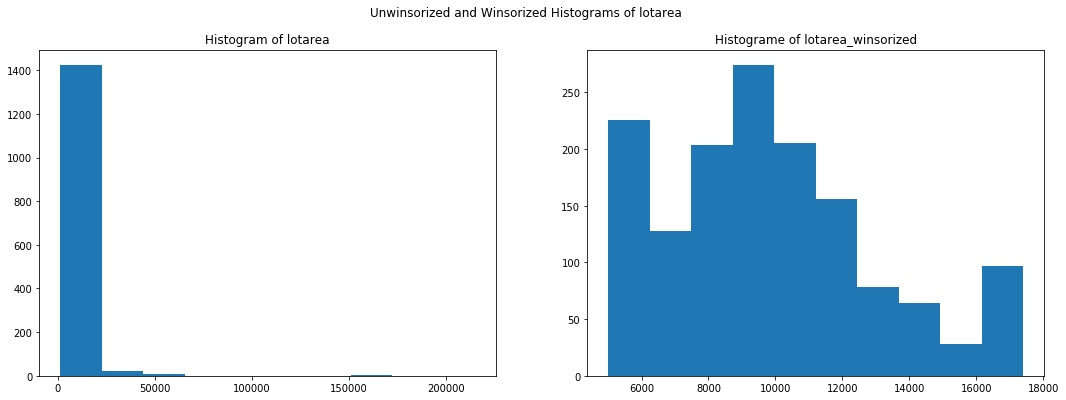

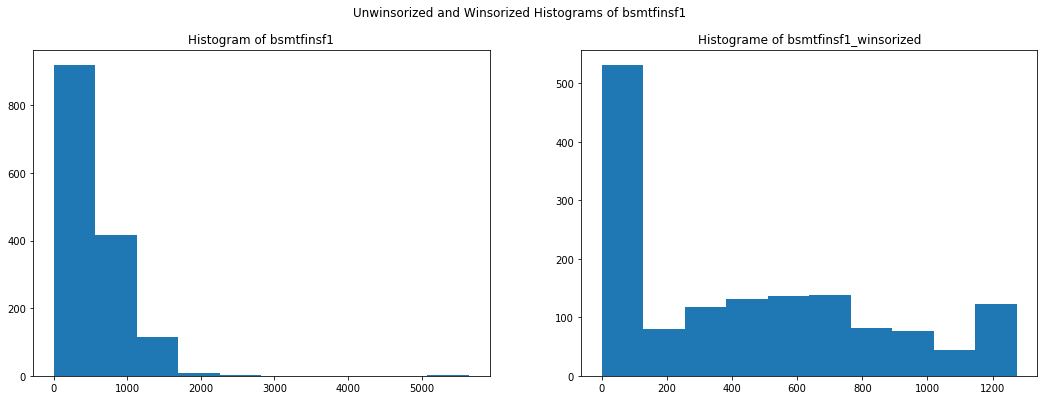

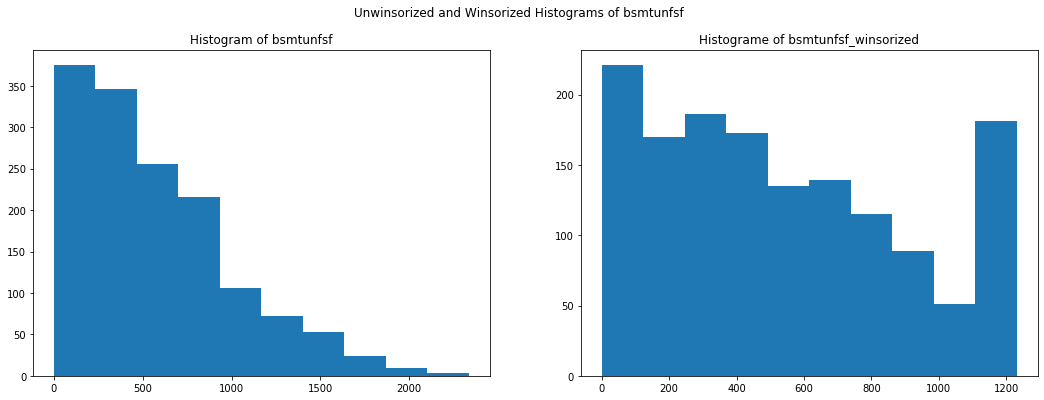

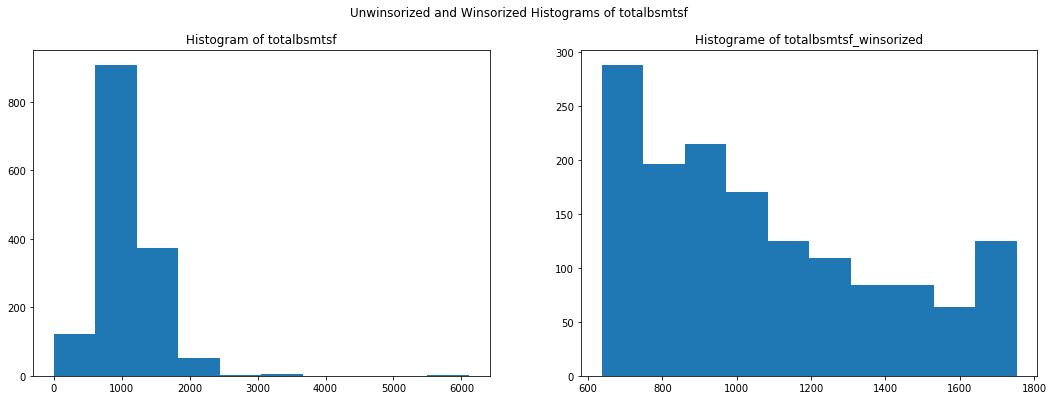

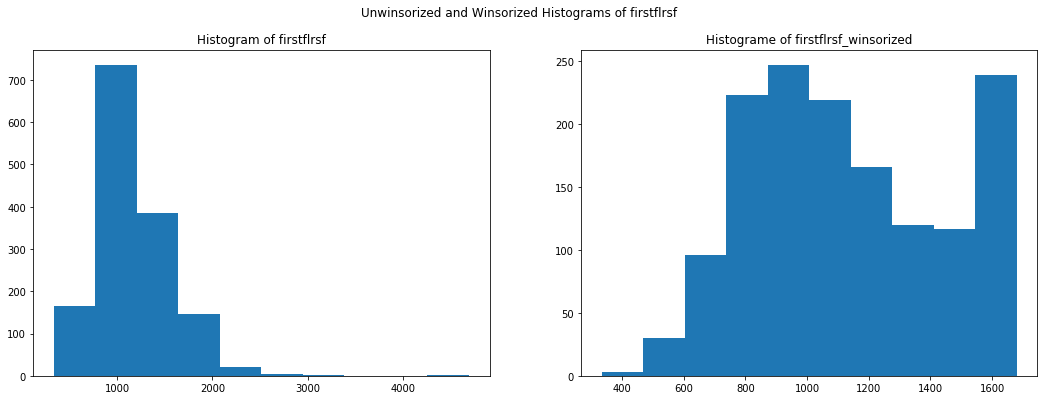

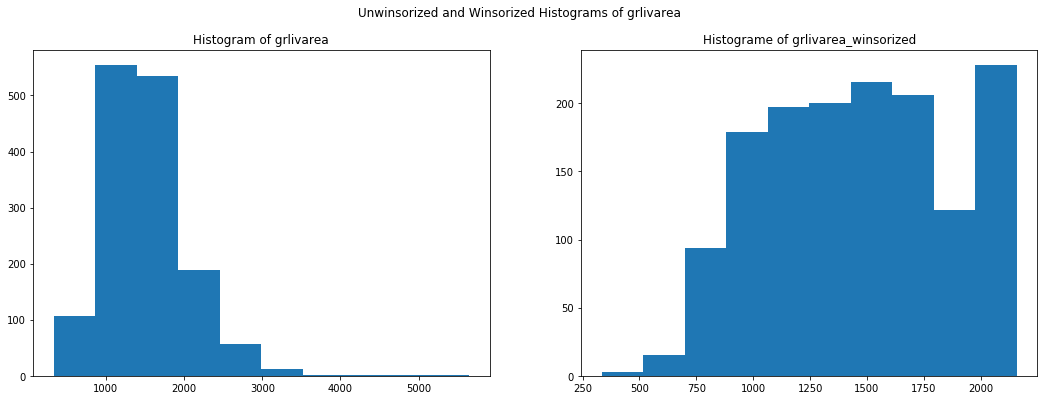

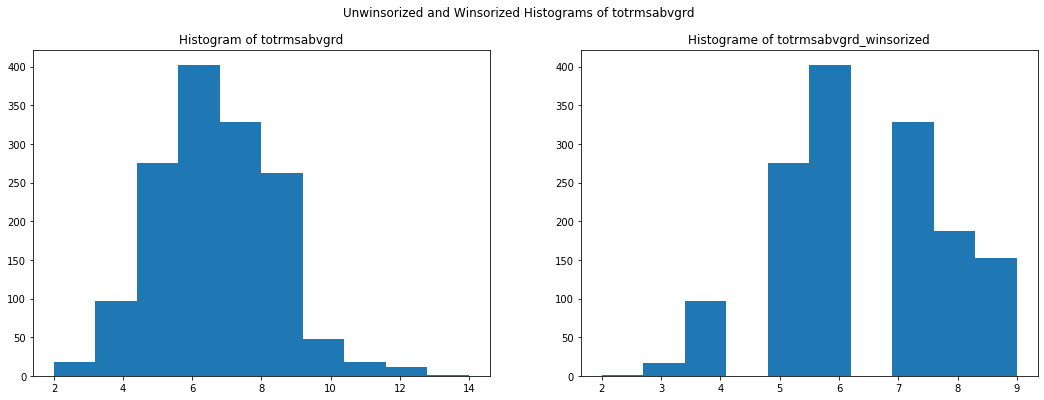

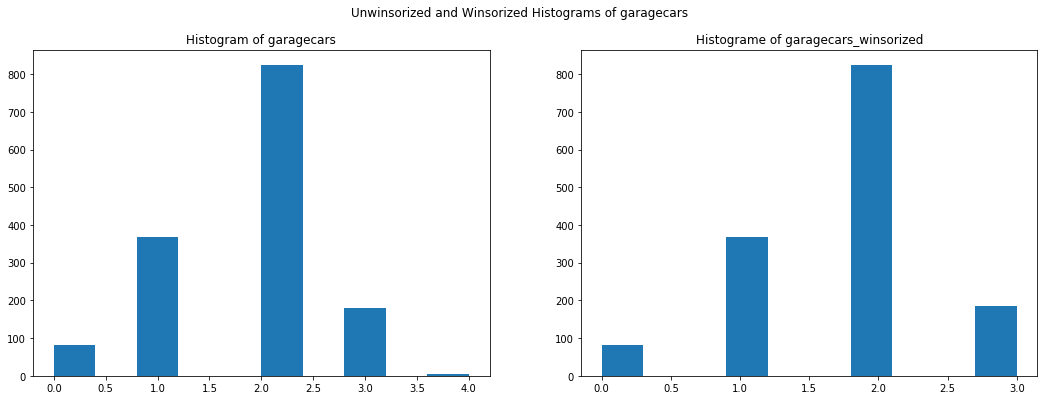

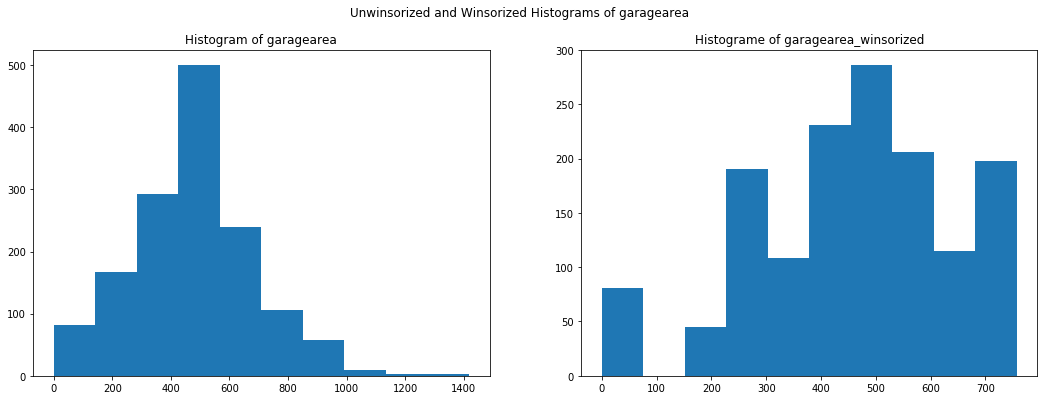

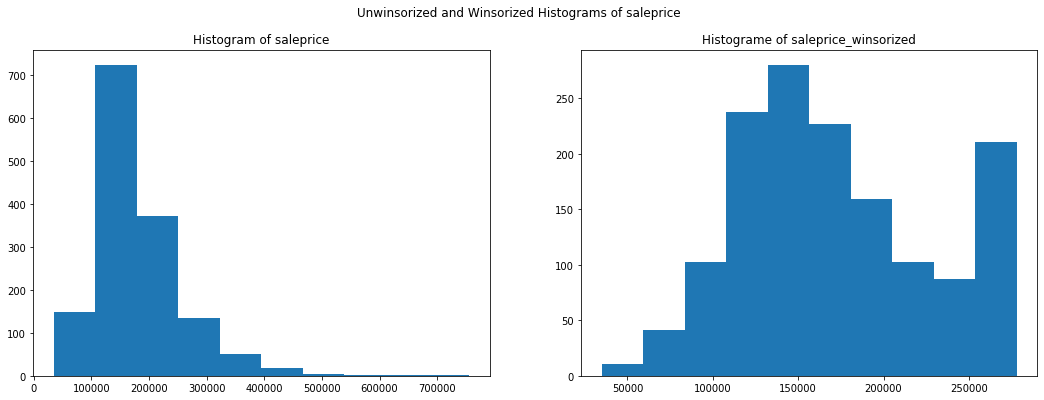

In [21]:
# Take a look at the distributions for the continuous variables to gain some insight
for k,v in enumerate(houses_winsorized.iloc[:,1:-10].select_dtypes(exclude=['object','category','datetime64[ns]']).columns):
    plt.figure(figsize=(18,6))
    
    plt.subplot(1,2,1)
    plt.hist(houses_winsorized[f"{v}"])
    plt.title(f"Histogram of {v}")
    
    plt.subplot(1,2,2)
    plt.hist(houses_winsorized[f"{v}_winsorized"])
    plt.title(f"Histograme of {v}_winsorized")
    
    plt.suptitle(f"Unwinsorized and Winsorized Histograms of {v}")
    plt.show()
    

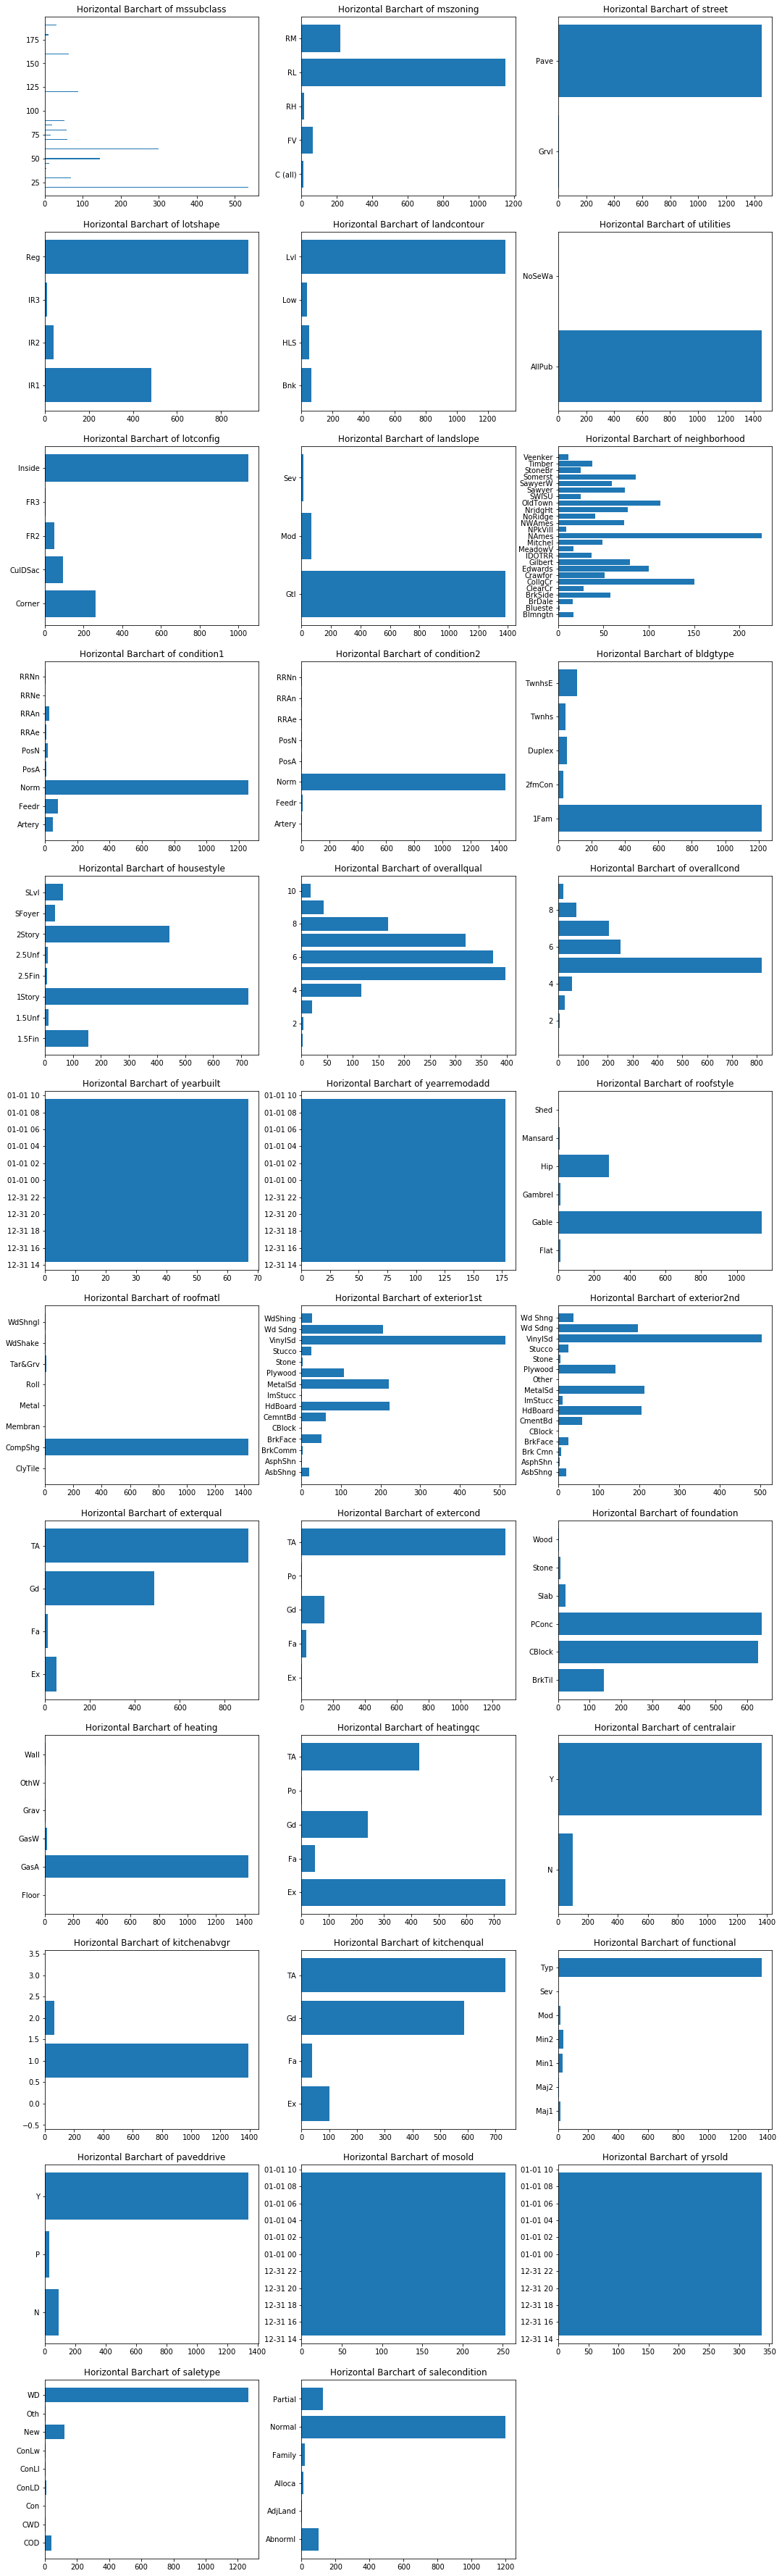

In [22]:
# Take a look at the categorical variables to see what information they 
plt.figure(figsize=(18,70))

for k,v in enumerate(houses_winsorized.iloc[:,1:-10].select_dtypes(include=['object','category','datetime64[ns]']).columns):

    
    plt.subplot(13,3,k+1)
    plt.barh(
        houses_winsorized.groupby(f"{v}")[f"{v}"].count().index,
        houses_winsorized.groupby(f"{v}")[f"{v}"].count()
    )
    
    plt.title(f"Horizontal Barchart of {v}")
    
plt.show();

### Bivariate Analysis of Continuous Variables

Take a look at the relationships between the continuous variables.  Visualize the relationships in a set of scatter plots, each with a fit line to help visualize a linear relationship.  Then take a look at a correlation matrix to see if any of the continuous variables are too tightly correlated to one another.

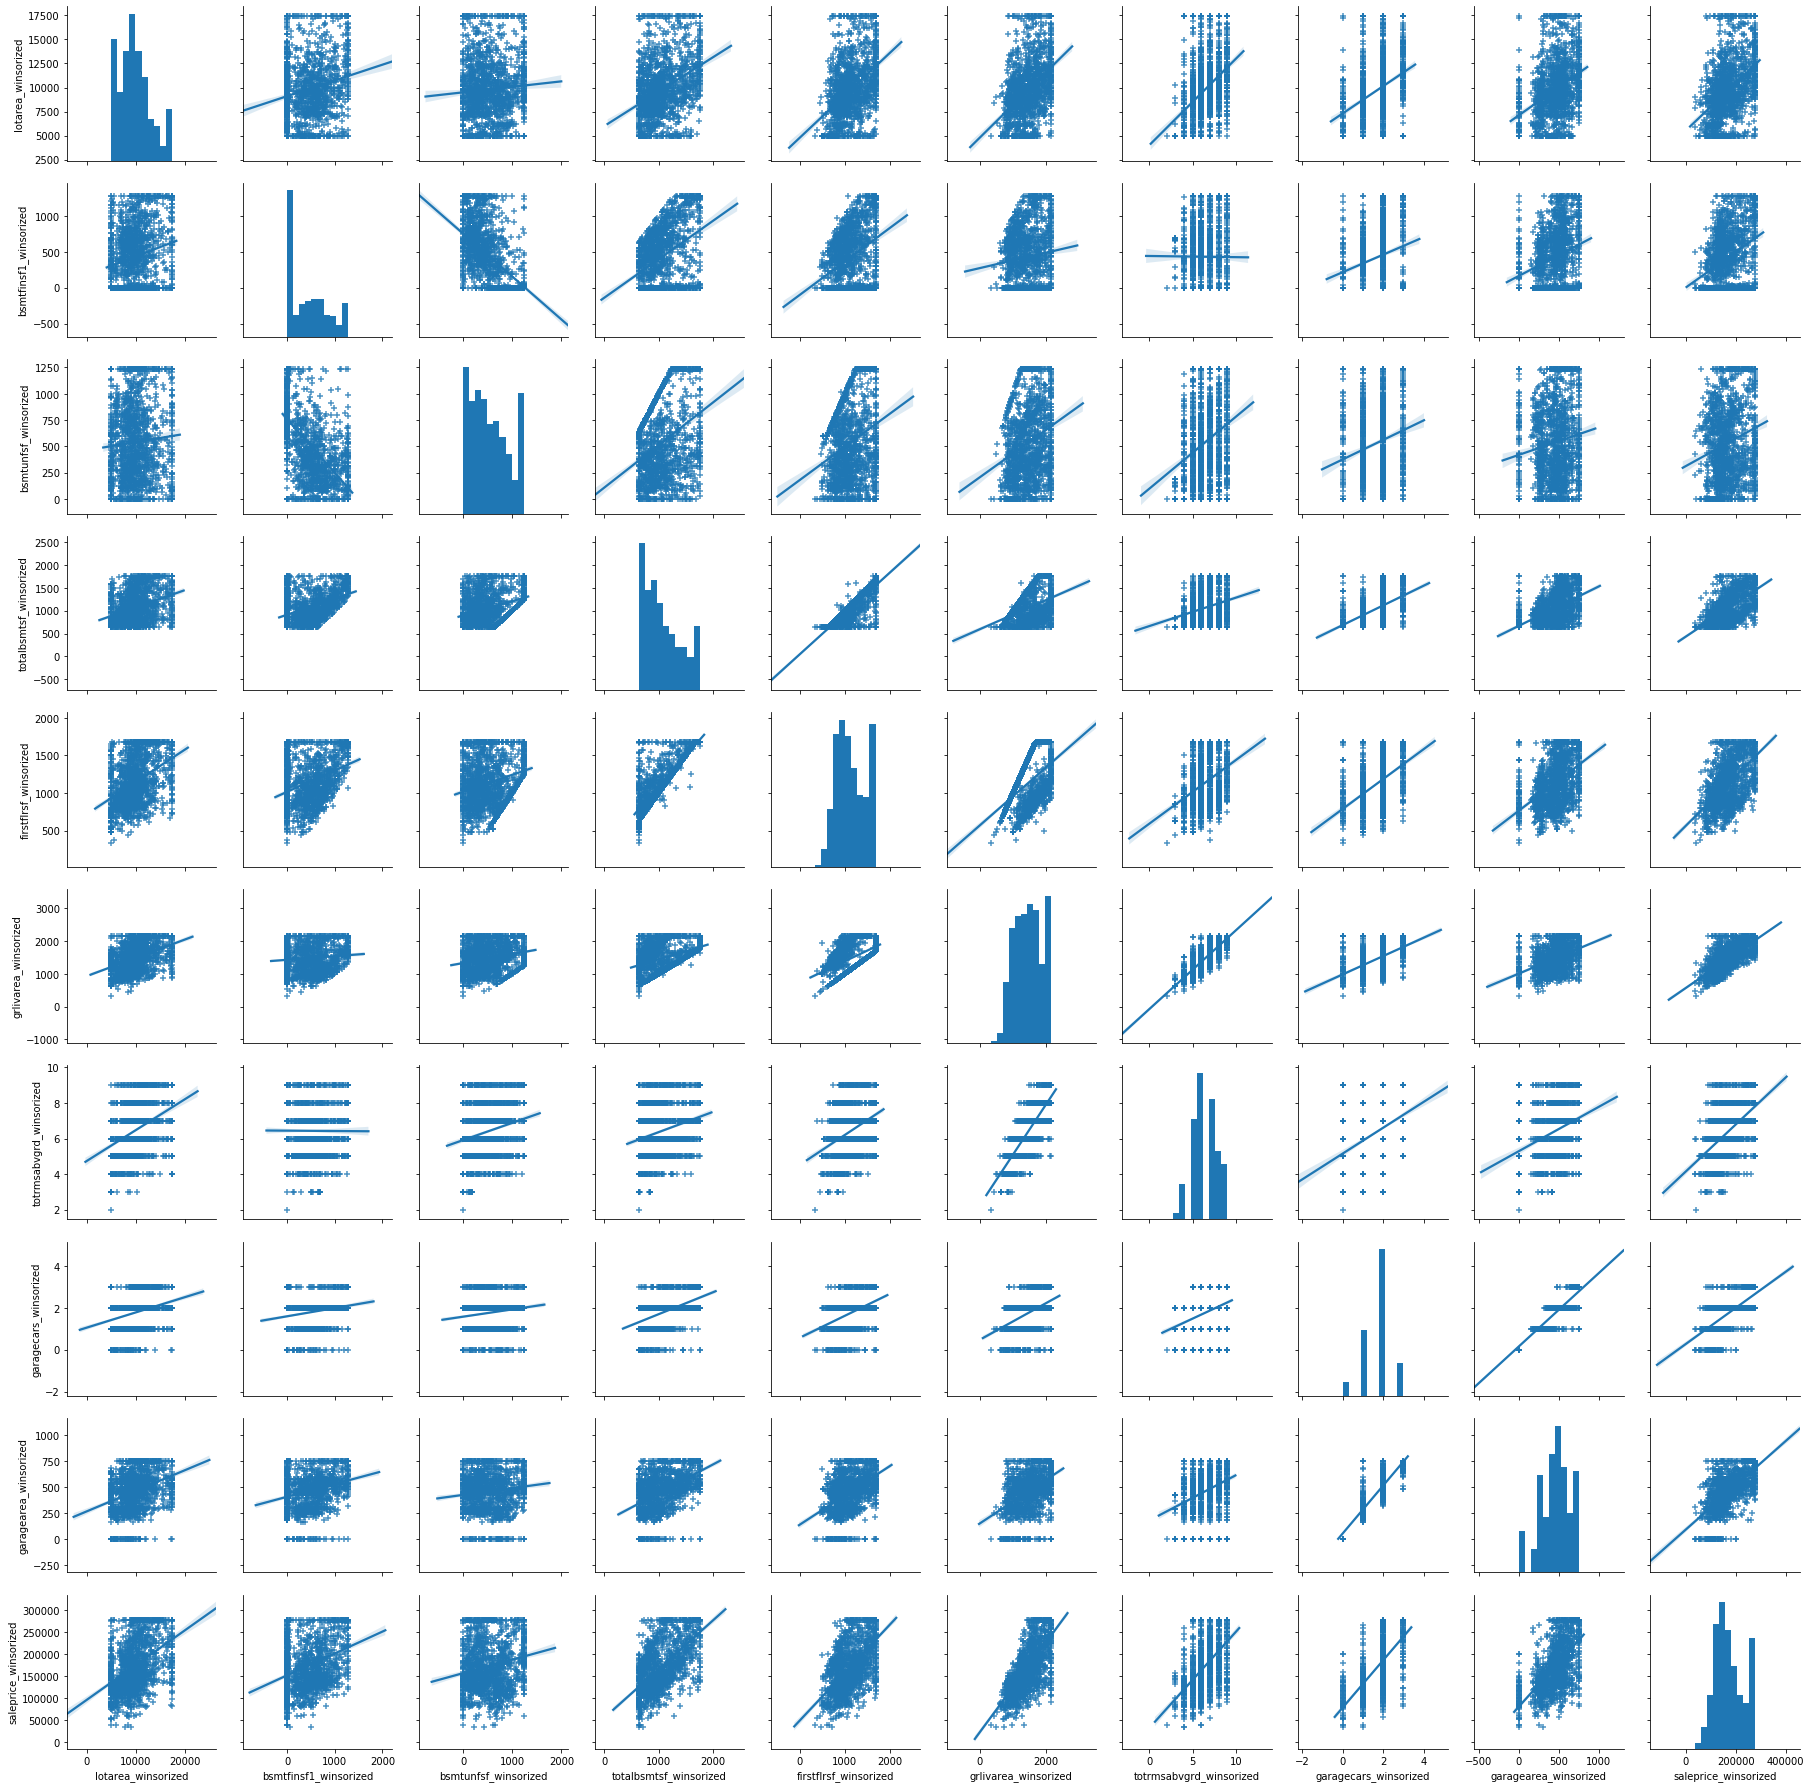

In [23]:
# Take a look at the pairplots for the continuous variables
houses = houses_winsorized.iloc[:,-10:].copy()
houses.fillna(0,inplace=True)
sns.pairplot(houses,kind="reg",markers="+")
plt.show();

In [24]:
# What are the correlation coefficients for the continuous variables
houses.corr()

,lotarea_winsorized,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,totalbsmtsf_winsorized,firstflrsf_winsorized,grlivarea_winsorized,totrmsabvgrd_winsorized,garagecars_winsorized,garagearea_winsorized,saleprice_winsorized
lotarea_winsorized,1.000000,0.206138,0.066678,0.366718,0.434628,0.435716,0.394812,0.320833,0.341492,0.440780
bsmtfinsf1_winsorized,0.206138,1.000000,-0.553295,0.435211,0.364088,0.108865,-0.005721,0.218618,0.268095,0.350001
bsmtunfsf_winsorized,0.066678,-0.553295,1.000000,0.355852,0.266409,0.248088,0.257838,0.179768,0.130801,0.200352
totalbsmtsf_winsorized,0.366718,0.435211,0.355852,1.000000,0.858762,0.397940,0.266509,0.474548,0.489302,0.634584
firstflrsf_winsorized,0.434628,0.364088,0.266409,0.858762,1.000000,0.501305,0.377394,0.455882,0.480421,0.600459
grlivarea_winsorized,0.435716,0.108865,0.248088,0.397940,0.501305,1.000000,0.826147,0.494956,0.464783,0.731478
totrmsabvgrd_winsorized,0.394812,-0.005721,0.257838,0.266509,0.377394,0.826147,1.000000,0.374316,0.330845,0.537040
garagecars_winsorized,0.320833,0.218618,0.179768,0.474548,0.455882,0.494956,0.374316,1.000000,0.901384,0.679407
garagearea_winsorized,0.341492,0.268095,0.130801,0.489302,0.480421,0.464783,0.330845,0.901384,1.000000,0.656599
saleprice_winsorized,0.440780,0.350001,0.200352,0.634584,0.600459,0.731478,0.537040,0.679407,0.656599,1.000000


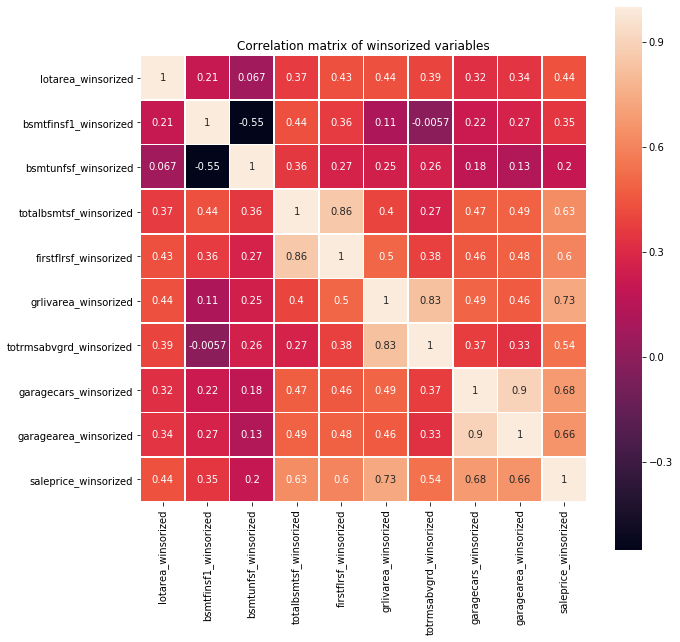

In [25]:
# Get a column count to set the figure size
col_count = len(houses.columns)

# Plot the correlation matrix
corr_plot(houses.corr(), (col_count,col_count))

### Bivariate Analysis of Continuous-Categorical pairs

In [26]:
# Construct a datafreame of the categorical columns and the winsorized continuous column subsets for use in a bivariate analysis
cat_houses = houses_winsorized.select_dtypes(include=['object','category','datetime64[ns]']).copy()

# cc_pair_df = pd.concat([cat_houses,houses])
cc_pair_df = cat_houses.join(houses)

# Order the columns to ease further analysis
col_order = ['bldgtype', 'centralair', 'condition1', 'condition2', 'extercond', 
'exterior1st', 'exterior2nd', 'exterqual', 'foundation', 'functional', 
'heating', 'heatingqc', 'housestyle', 'kitchenabvgr', 'kitchenqual', 
'landcontour', 'landslope', 'lotconfig', 'lotshape', 'mssubclass', 
'mszoning', 'neighborhood', 'overallcond', 'overallqual', 'paveddrive', 
'roofmatl', 'roofstyle', 'salecondition', 'saletype', 'street', 
'utilities', 'bsmtfinsf1_winsorized', 'bsmtunfsf_winsorized', 'firstflrsf_winsorized', 
'garagearea_winsorized', 'garagecars_winsorized', 'grlivarea_winsorized', 'lotarea_winsorized', 
'saleprice_winsorized', 'totalbsmtsf_winsorized', 'totrmsabvgrd_winsorized']

cc_pair_df = cc_pair_df[col_order]

cc_pair_df 

,bldgtype,centralair,condition1,condition2,extercond,exterior1st,exterior2nd,exterqual,foundation,functional,...,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
0,1Fam,Y,Norm,Norm,TA,VinylSd,VinylSd,Gd,PConc,Typ,...,706,150,856,548,2,1710,8450,208500,856,8
1,1Fam,Y,Feedr,Norm,TA,MetalSd,MetalSd,TA,CBlock,Typ,...,978,284,1262,460,2,1262,9600,181500,1262,6
2,1Fam,Y,Norm,Norm,TA,VinylSd,VinylSd,Gd,PConc,Typ,...,486,434,920,608,2,1786,11250,223500,920,6
3,1Fam,Y,Norm,Norm,TA,Wd Sdng,Wd Shng,TA,BrkTil,Typ,...,216,540,961,642,3,1717,9550,140000,756,7
4,1Fam,Y,Norm,Norm,TA,VinylSd,VinylSd,Gd,PConc,Typ,...,655,490,1145,757,3,2158,14260,250000,1145,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1Fam,Y,Norm,Norm,TA,VinylSd,VinylSd,TA,PConc,Typ,...,0,953,953,460,2,1647,7917,175000,953,7
1456,1Fam,Y,Norm,Norm,TA,Plywood,Plywood,TA,CBlock,Min1,...,790,589,1680,500,2,2073,13175,210000,1542,7
1457,1Fam,Y,Norm,Norm,Gd,CemntBd,CmentBd,Ex,Stone,Typ,...,275,877,1188,252,1,2158,9042,266500,1152,9
1458,1Fam,Y,Norm,Norm,TA,MetalSd,MetalSd,TA,CBlock,Typ,...,49,0,1078,240,1,1078,9717,142125,1078,5


In [87]:
for k1,v1 in enumerate(cc_pair_df.select_dtypes(include=["object","category"]).columns):
    select_cols = cc_pair_df.select_dtypes(exclude=["object","category","datetime64[ns]"]).columns.to_list()
    select_cols.insert(0,v1)
    display(cc_pair_df[select_cols].groupby(f"{v1}").mean())

#     plt.figure(figsize=(18,55))

#     for k2, v2 in enumerate(cc_pair_df[select_cols].iloc[:,1:].columns):
#         plt.subplot(4,3,k2+1)

#         sns.barplot(cc_pair_df[f"{v1}"],cc_pair_df[f"{v2}"])
#         plt.xticks(rotation=60)
#         plt.title(f"count of {v1} by {v2}")
        
#     plt.subplots_adjust(bottom=2.0,top=2.5)    
#     plt.show();

,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
bldgtype,,,,,,,,,,
1Fam,430.796721,553.971311,1146.076230,468.912295,1.778689,1489.495902,10357.173770,176628.788525,1071.513115,6.528689
2fmCon,439.354839,395.806452,1038.741935,329.096774,1.193548,1498.967742,10009.935484,128432.258065,906.129032,6.903226
Duplex,394.980769,439.230769,1302.634615,416.500000,1.634615,1544.653846,9545.250000,133541.076923,1125.807692,7.326923
Twnhs,334.279070,389.488372,763.511628,355.255814,1.441860,1276.418605,5010.348837,135911.627907,791.627907,5.558140
TwnhsE,484.956140,525.552632,1134.263158,472.385965,1.938596,1309.140351,5766.833333,178532.543860,1107.140351,5.228070


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
centralair,,,,,,,,,,
N,155.936842,519.600000,939.463158,282.357895,1.094737,1304.010526,8451.063158,105264.073684,824.042105,6.189474
Y,450.238828,540.845421,1150.944322,473.433700,1.810256,1482.946520,9899.213187,177735.883516,1081.207326,6.452015


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
condition1,,,,,,,,,,
Artery,252.125000,536.395833,1004.833333,388.791667,1.458333,1439.833333,9610.770833,130008.333333,874.895833,6.395833
Feedr,416.666667,445.814815,1115.740741,406.567901,1.481481,1421.950617,9668.098765,142475.481481,986.172840,6.456790
Norm,436.864286,545.447619,1139.490476,464.557143,1.781746,1465.653968,9718.952381,175853.860317,1075.227778,6.398413
PosA,534.000000,590.375000,1537.875000,566.625000,2.000000,1968.000000,15006.125000,218750.000000,1219.875000,7.625000
PosN,602.894737,611.842105,1343.947368,524.526316,2.000000,1833.684211,11360.473684,207710.526316,1201.894737,7.578947
RRAe,559.181818,425.636364,1209.727273,489.636364,1.818182,1339.090909,11713.727273,138400.000000,1069.181818,6.363636
RRAn,318.730769,536.961538,1038.576923,485.076923,1.961538,1558.384615,11393.730769,178630.384615,978.000000,6.884615
RRNe,414.000000,500.000000,923.000000,481.500000,2.000000,1727.000000,9372.000000,190750.000000,914.000000,7.000000
RRNn,419.200000,500.600000,1185.800000,533.000000,2.200000,1560.600000,9046.800000,201600.000000,1171.600000,7.000000


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
condition2,,,,,,,,,,
Artery,645.500000,339.000000,1045.500000,312.500000,1.500000,1388.000000,9017.500000,106500.000000,984.500000,6.000000
Feedr,0.000000,695.666667,919.500000,399.666667,1.500000,1467.333333,8812.833333,121166.666667,732.333333,6.333333
Norm,432.438062,538.275433,1137.310035,460.677509,1.763322,1470.546713,9795.988235,173293.019377,1064.721799,6.432526
PosA,0.000000,1232.000000,1521.000000,757.000000,2.000000,2158.000000,13500.000000,278000.000000,1237.000000,9.000000
PosN,1274.000000,660.000000,1680.000000,757.000000,3.000000,2121.000000,16101.500000,231375.000000,1753.000000,8.000000
RRAe,498.000000,652.000000,1361.000000,600.000000,2.000000,2158.000000,17400.000000,190000.000000,1361.000000,9.000000
RRAn,0.000000,1232.000000,1680.000000,528.000000,2.000000,1680.000000,11500.000000,136905.000000,1680.000000,8.000000
RRNn,90.000000,260.000000,672.500000,480.000000,1.500000,672.500000,7279.500000,96750.000000,731.000000,4.000000


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
extercond,,,,,,,,,,
Ex,47.000000,826.000000,969.333333,372.333333,1.333333,1411.333333,10835.000000,185666.666667,874.666667,6.666667
Fa,180.607143,508.071429,961.857143,233.000000,0.857143,1281.285714,8316.107143,102595.142857,811.857143,6.107143
Gd,459.931507,437.500000,1111.732877,428.760274,1.547945,1426.260274,9997.719178,162984.554795,982.226027,6.335616
Po,0.000000,728.000000,1306.000000,0.000000,0.000000,1306.000000,5350.000000,76500.000000,728.000000,6.000000
TA,434.510140,550.943058,1144.172387,470.219189,1.810452,1480.852574,9816.617785,175747.003900,1080.064743,6.453198


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
exterior1st,,,,,,,,,,
AsbShng,139.900000,551.250000,944.550000,295.750000,1.150000,1354.400000,7923.450000,107385.550000,795.250000,6.250000
AsphShn,0.000000,0.000000,1664.000000,0.000000,0.000000,1664.000000,9825.000000,100000.000000,637.000000,8.000000
BrkComm,0.000000,616.000000,1110.000000,439.000000,1.500000,1110.000000,9888.500000,71000.000000,956.500000,4.500000
BrkFace,465.120000,533.500000,1312.560000,431.000000,1.660000,1547.280000,10645.180000,184951.000000,1183.240000,6.500000
CBlock,315.000000,420.000000,840.000000,338.000000,1.000000,1374.000000,5400.000000,105000.000000,840.000000,6.000000
CemntBd,611.049180,519.180328,1243.868852,494.819672,1.901639,1572.262295,9044.967213,202676.327869,1223.016393,6.672131
HdBoard,509.644144,418.252252,1081.963964,443.495495,1.657658,1365.855856,9996.315315,159016.639640,1011.261261,6.234234
ImStucc,1274.000000,168.000000,1624.000000,757.000000,3.000000,1624.000000,12461.000000,262000.000000,1624.000000,5.000000
MetalSd,383.627273,498.340909,1021.250000,400.272727,1.477273,1337.272727,8627.477273,147153.290909,948.331818,6.018182


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
exterior2nd,,,,,,,,,,
AsbShng,170.050000,581.250000,954.950000,305.150000,1.150000,1403.350000,8536.200000,114060.550000,816.900000,6.300000
AsphShn,244.333333,55.333333,1093.666667,275.666667,1.000000,1505.333333,10675.000000,138000.000000,658.666667,6.666667
Brk Cmn,285.857143,422.857143,920.571429,439.714286,1.857143,1349.000000,6396.714286,126714.285714,876.714286,6.142857
BrkFace,488.720000,589.120000,1309.400000,398.560000,1.600000,1478.800000,10502.880000,182538.000000,1235.560000,6.240000
CBlock,315.000000,420.000000,840.000000,338.000000,1.000000,1374.000000,5400.000000,105000.000000,840.000000,6.000000
CmentBd,583.533333,541.133333,1240.650000,493.283333,1.900000,1572.183333,8889.700000,203254.266667,1225.316667,6.683333
HdBoard,524.855072,419.772947,1102.946860,452.028986,1.681159,1401.705314,10071.734300,162987.652174,1029.821256,6.333333
ImStucc,724.600000,424.600000,1314.800000,559.100000,2.100000,1525.100000,9890.100000,194870.000000,1307.300000,6.200000
MetalSd,389.443925,495.752336,1023.439252,401.406542,1.485981,1335.425234,8585.616822,147470.672897,950.873832,6.014019


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
exterqual,,,,,,,,,,
Ex,772.769231,701.096154,1560.961538,689.846154,2.711538,1940.230769,12330.576923,266191.211538,1585.423077,7.942308
Fa,93.214286,526.428571,850.428571,235.214286,0.857143,1094.000000,8281.428571,87985.214286,818.071429,5.357143
Gd,470.079918,666.997951,1244.829918,565.659836,2.213115,1678.631148,10070.971311,219681.034836,1216.983607,6.836066
TA,395.697572,461.693157,1059.310155,394.982340,1.481236,1338.546358,9540.301325,143853.738411,956.235099,6.149007


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
foundation,,,,,,,,,,
BrkTil,165.842466,627.082192,975.027397,341.212329,1.308219,1397.410959,8833.369863,130503.404110,838.273973,6.458904
CBlock,473.381703,433.197161,1104.648265,405.159306,1.490536,1334.929022,9988.826498,148678.331230,1013.596215,6.070978
PConc,467.392581,643.171561,1207.870170,545.638331,2.145286,1622.984544,9871.265842,208909.550232,1182.820711,6.774343
Slab,0.000000,0.000000,1098.250000,375.041667,1.500000,1329.291667,8936.375000,107365.625000,637.000000,6.333333
Stone,45.833333,847.833333,1093.833333,446.500000,1.500000,1748.333333,9014.666667,165959.166667,983.666667,7.833333
Wood,791.666667,65.333333,1058.000000,555.000000,2.000000,1757.333333,12473.000000,185666.666667,883.000000,7.000000


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
functional,,,,,,,,,,
Maj1,319.857143,591.357143,1270.000000,356.142857,1.500000,1666.285714,9029.714286,151305.285714,1080.428571,7.142857
Maj2,49.400000,767.400000,1077.200000,286.800000,1.000000,1171.800000,9041.400000,85800.000000,1015.200000,5.200000
Min1,472.645161,340.870968,1278.870968,441.580645,1.612903,1512.193548,10024.580645,146385.483871,992.967742,6.516129
Min2,331.500000,471.911765,1239.588235,431.058824,1.500000,1623.705882,10930.676471,143105.352941,943.558824,6.705882
Mod,372.933333,550.866667,1323.800000,434.400000,1.600000,1646.600000,10903.800000,151060.000000,1200.333333,6.800000
Sev,187.000000,111.000000,1465.000000,596.000000,2.000000,2158.000000,17400.000000,129000.000000,1021.000000,7.000000
Typ,436.000735,544.495588,1127.947794,464.105882,1.780882,1463.216912,9764.920588,175194.016176,1067.677206,6.419118


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
heating,,,,,,,,,,
Floor,0.000000,0.000000,720.000000,287.000000,1.000000,720.000000,6627.000000,72500.000000,637.000000,4.000000
GasA,434.778711,541.399860,1139.549020,463.681373,1.772409,1471.766807,9811.460784,174011.126751,1068.176471,6.435574
GasW,422.222222,526.833333,1163.000000,450.500000,1.722222,1700.722222,10670.444444,161243.277778,1065.333333,6.944444
Grav,49.714286,596.142857,725.428571,96.000000,0.428571,888.857143,8324.714286,75271.428571,713.714286,4.714286
OthW,289.000000,420.500000,1036.000000,198.000000,1.000000,2108.000000,7425.000000,125750.000000,709.500000,8.000000
Wall,0.000000,0.000000,1052.000000,365.000000,1.750000,1162.250000,8173.250000,92100.000000,637.000000,6.750000


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
heatingqc,,,,,,,,,,
Ex,461.933873,613.645074,1204.670715,517.811066,2.008097,1581.866397,10018.831309,200360.747638,1157.056680,6.686910
Fa,259.163265,485.489796,993.020408,324.897959,1.326531,1281.979592,9264.020408,123919.489796,880.448980,6.122449
Gd,380.921162,498.717842,1060.863071,410.991701,1.593361,1408.663900,9458.854772,155128.580913,964.473029,6.298755
Po,116.000000,604.000000,803.000000,360.000000,2.000000,803.000000,5000.000000,87000.000000,720.000000,5.000000
TA,426.355140,440.002336,1080.602804,406.621495,1.485981,1338.392523,9702.808411,141582.268692,982.366822,6.114486


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
housestyle,,,,,,,,,,
1.5Fin,245.058442,564.714286,997.922078,346.071429,1.285714,1523.285714,9347.253247,141077.129870,874.811688,6.636364
1.5Unf,149.071429,677.785714,896.428571,266.928571,1.142857,896.428571,7162.428571,110150.000000,826.857143,4.714286
1Story,511.046832,571.278237,1269.151515,466.198347,1.760331,1302.979339,9811.067493,168915.870523,1212.002755,5.884298
2.5Fin,144.625000,788.000000,1333.875000,442.250000,1.500000,2158.000000,11651.125000,193250.000000,968.500000,8.750000
2.5Unf,192.636364,687.727273,1030.454545,349.181818,1.454545,1839.454545,9153.272727,153081.818182,890.545455,8.000000
2Story,353.328090,535.732584,987.779775,502.685393,1.991011,1783.368539,10045.370787,197106.274157,934.995506,7.400000
SFoyer,730.135135,75.756757,934.243243,421.837838,1.513514,973.378378,8278.621622,135074.486486,889.837838,4.891892
SLvl,477.261538,328.307692,1177.215385,475.184615,1.738462,1352.184615,10496.876923,165672.615385,944.307692,6.200000


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
kitchenabvgr,,,,,,,,,,
0,945.000000,0.000000,980.000000,0.000000,0.000000,980.000000,9400.000000,127500.000000,945.000000,4.000000
1,438.075431,539.254310,1131.273707,464.250000,1.775144,1460.821839,9823.826149,175101.880747,1064.305316,6.366379
2,286.830769,544.446154,1273.292308,407.153846,1.569231,1693.369231,9507.861538,131096.153846,1078.292308,7.876923
3,0.000000,792.500000,905.500000,180.000000,1.000000,1795.000000,6550.000000,109500.000000,792.500000,8.500000


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
kitchenqual,,,,,,,,,,
Ex,731.570000,655.660000,1484.300000,646.300000,2.520000,1869.180000,11995.740000,256491.160000,1480.180000,7.540000
Fa,136.512821,565.512821,928.897436,214.564103,0.794872,1221.589744,8500.974359,105565.205128,836.000000,5.692308
Gd,448.037543,613.914676,1203.155290,534.897611,2.073379,1611.250853,9874.196246,205051.302048,1146.703072,6.687713
TA,392.325170,462.912925,1048.410884,389.949660,1.465306,1318.843537,9520.933333,139705.232653,954.478912,6.122449


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
landcontour,,,,,,,,,,
Bnk,295.047619,529.603175,1093.873016,357.793651,1.380952,1486.603175,9378.365079,142516.777778,896.825397,6.634921
HLS,490.220000,576.600000,1227.640000,524.020000,2.100000,1574.860000,11010.940000,207017.020000,1174.380000,6.680000
Low,778.055556,305.916667,1284.305556,502.277778,1.861111,1512.694444,13956.694444,196200.000000,1244.361111,6.027778
Lvl,425.843631,544.933638,1131.774981,462.423341,1.766590,1465.482075,9665.485889,172552.982456,1063.398932,6.427155


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
landslope,,,,,,,,,,
Gtl,419.206223,550.093343,1131.577424,460.860347,1.764110,1467.100579,9691.128799,172235.252533,1062.298842,6.446454
Mod,620.738462,367.600000,1215.569231,461.923077,1.769231,1531.723077,11094.015385,185300.292308,1077.661538,6.307692
Sev,746.076923,268.692308,1341.230769,471.307692,1.692308,1616.000000,15463.538462,195071.538462,1229.769231,5.846154


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
lotconfig,,,,,,,,,,
Corner,395.889734,570.463878,1149.076046,474.501901,1.794677,1510.228137,10454.745247,173411.730038,1060.106464,6.543726
CulDSac,577.489362,489.808511,1250.680851,522.797872,2.021277,1608.914894,12599.095745,206365.904255,1175.159574,6.659574
FR2,494.085106,455.276596,1081.744681,466.680851,1.893617,1427.319149,10208.191489,173166.127660,1040.063830,6.340426
FR3,611.000000,505.750000,1125.500000,562.250000,2.250000,1538.000000,9022.500000,199225.000000,1109.750000,6.500000
Inside,423.308935,540.038973,1126.590304,451.464829,1.725285,1450.987643,9377.841255,169836.673004,1056.594106,6.391635


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
lotshape,,,,,,,,,,
IR1,505.985537,543.890496,1214.382231,504.768595,1.935950,1562.322314,10932.537190,194109.785124,1144.892562,6.652893
IR2,448.341463,537.243902,1212.926829,541.536585,2.146341,1688.512195,13470.951220,213737.414634,1149.560976,6.853659
IR3,657.600000,510.300000,1252.800000,538.100000,2.100000,1733.100000,15138.100000,206336.500000,1232.400000,7.200000
Reg,388.686486,537.560000,1092.182703,433.696216,1.652973,1411.220541,8994.852973,159820.360000,1016.808649,6.294054


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
mssubclass,,,,,,,,,,
20,546.998134,570.020522,1297.826493,489.871269,1.822761,1340.356343,10623.617537,176378.020522,1247.462687,6.033582
30,187.826087,579.811594,903.681159,271.318841,1.000000,908.898551,7869.347826,95829.724638,824.304348,4.855072
40,500.750000,513.000000,1074.000000,349.500000,1.250000,1335.750000,11011.000000,156125.000000,1013.750000,4.750000
45,103.000000,699.750000,876.750000,278.333333,1.166667,876.750000,7000.000000,108591.666667,802.750000,4.750000
50,224.972222,589.583333,984.534722,344.541667,1.277778,1515.368056,9264.833333,141121.722222,871.534722,6.604167
60,416.535117,550.153846,1054.190635,564.642140,2.227425,1885.494983,11199.966555,221076.785953,1007.277592,7.712375
70,181.416667,604.583333,968.283333,371.983333,1.483333,1718.600000,9926.233333,164804.083333,806.883333,7.466667
75,188.125000,696.500000,1142.437500,415.625000,1.562500,1955.812500,10722.062500,176125.000000,918.000000,8.125000
80,479.517241,351.827586,1192.758621,476.913793,1.741379,1369.068966,10745.310345,168581.379310,970.172414,6.258621


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
mszoning,,,,,,,,,,
C (all),222.800000,547.600000,851.400000,380.700000,1.300000,1178.100000,9441.300000,74528.000000,795.800000,5.900000
FV,327.892308,637.123077,989.907692,567.461538,2.123077,1562.846154,7363.276923,209013.984615,996.123077,6.138462
RH,312.750000,506.312500,996.937500,317.250000,1.125000,1432.812500,7574.562500,131558.375000,873.375000,6.500000
RL,477.199826,536.610773,1191.807993,478.927889,1.832320,1503.121633,10508.583840,181591.551694,1116.463944,6.556907
RM,236.642202,527.463303,916.091743,348.839450,1.362385,1292.288991,6998.522936,124594.353211,836.706422,5.899083


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
neighborhood,,,,,,,,,,
Blmngtn,196.000000,1070.294118,1427.941176,502.764706,2.352941,1427.941176,5000.000000,194870.882353,1324.411765,6.411765
Blueste,183.000000,149.500000,638.500000,457.000000,2.000000,1392.500000,5000.000000,137500.000000,676.500000,5.500000
BrDale,250.437500,333.437500,583.875000,284.000000,1.125000,1143.187500,5000.000000,104493.750000,659.562500,5.750000
BrkSide,195.137931,558.517241,914.724138,303.241379,1.172414,1203.068966,7311.689655,124834.051724,824.017241,5.568966
ClearCr,619.107143,446.964286,1295.464286,468.428571,1.750000,1730.821429,14172.321429,209851.142857,1249.857143,6.714286
CollgCr,453.253333,621.380000,1157.613333,541.646667,2.006667,1466.060000,9656.953333,195500.886667,1154.753333,6.326667
Crawfor,452.196078,520.725490,1210.627451,397.431373,1.627451,1698.549020,11296.843137,202054.137255,1027.078431,7.058824
Edwards,369.240000,445.390000,1042.780000,318.210000,1.180000,1279.170000,9603.750000,127799.700000,921.380000,6.070000
Gilbert,213.113924,640.797468,941.670886,452.088608,2.063291,1630.126582,10833.493671,191063.367089,897.253165,7.101266


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
overallcond,,,,,,,,,,
1,350.000000,333.000000,904.000000,0.000000,0.000000,904.000000,10020.000000,61000.000000,683.000000,4.000000
2,254.800000,841.600000,1234.200000,370.400000,1.400000,1507.800000,8756.200000,118700.000000,1110.000000,6.800000
3,299.560000,524.640000,1059.760000,307.440000,1.160000,1242.400000,9250.240000,101929.400000,987.360000,5.840000
4,290.263158,541.368421,1125.473684,377.578947,1.403509,1434.771930,10157.701754,120438.438596,979.140351,6.526316
5,464.455542,593.294762,1192.721072,514.163216,2.012180,1549.668697,9934.685749,191146.980512,1151.520097,6.605359
6,444.615079,451.329365,1074.658730,413.615079,1.492063,1365.007937,9613.563492,150973.099206,981.194444,6.138889
7,373.429268,456.634146,1057.117073,379.868293,1.419512,1362.170732,9678.146341,156921.097561,931.575610,6.204878
8,377.569444,450.819444,993.597222,379.680556,1.402778,1341.263889,8996.638889,153657.291667,887.763889,6.180556
9,301.500000,554.636364,1103.681818,474.181818,1.772727,1579.181818,10929.909091,196945.454545,902.409091,6.909091


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
overallqual,,,,,,,,,,
1,175.000000,166.500000,619.000000,0.000000,0.000000,619.000000,7510.000000,50150.000000,660.000000,3.000000
2,113.333333,231.333333,572.666667,184.666667,0.666667,572.666667,7840.000000,51770.333333,637.000000,3.666667
3,90.750000,463.500000,948.750000,285.900000,1.200000,1119.150000,8408.550000,87473.750000,770.200000,5.900000
4,300.439655,428.594828,936.258621,316.387931,1.146552,1104.913793,8706.905172,108420.655172,838.594828,5.474138
5,422.483627,422.113350,1058.712846,380.488665,1.365239,1242.198992,9463.345088,133523.347607,963.508816,5.954660
6,418.366310,503.847594,1077.286096,428.818182,1.689840,1447.005348,9551.200535,161603.034759,991.770053,6.299465
7,385.905956,653.068966,1171.536050,525.564263,2.056426,1668.805643,9920.727273,205416.761755,1109.601881,6.868339
8,562.494048,713.708333,1398.666667,638.154762,2.458333,1826.553571,10732.190476,252202.696429,1375.940476,7.297619
9,766.395349,699.651163,1600.697674,706.186047,2.813953,1932.372093,12588.720930,276479.813953,1639.674419,7.767442


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
paveddrive,,,,,,,,,,
N,135.677778,571.333333,935.155556,245.677778,0.988889,1329.777778,8964.100000,115039.122222,819.744444,6.400000
P,192.466667,628.500000,995.566667,350.033333,1.233333,1384.633333,10427.900000,132330.000000,864.666667,6.300000
Y,456.272388,535.329104,1153.923134,477.947015,1.827612,1482.749254,9847.515672,177825.482836,1085.384328,6.440299


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
roofmatl,,,,,,,,,,
ClyTile,1274.000000,466.000000,1680.000000,757.000000,2.000000,2158.000000,17400.000000,160000.000000,1753.000000,9.000000
CompShg,427.951185,540.723152,1131.817992,459.646444,1.760112,1466.193863,9714.831939,172311.783821,1061.366806,6.429568
Membran,226.000000,96.000000,1363.000000,439.000000,2.000000,1363.000000,17400.000000,241500.000000,1385.000000,5.000000
Metal,938.000000,0.000000,988.000000,540.000000,2.000000,988.000000,17400.000000,180000.000000,938.000000,4.000000
Roll,220.000000,708.000000,928.000000,400.000000,2.000000,1920.000000,11345.000000,137000.000000,928.000000,9.000000
Tar&Grv,517.818182,327.181818,1393.454545,456.636364,1.636364,1676.090909,14513.545455,185406.363636,1080.000000,6.272727
WdShake,484.600000,564.800000,1506.600000,572.000000,2.000000,1903.200000,14558.800000,239600.000000,1220.200000,7.200000
WdShngl,821.833333,754.333333,1573.500000,651.500000,2.500000,1866.500000,14703.333333,259750.000000,1524.500000,7.166667


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
roofstyle,,,,,,,,,,
Flat,532.153846,235.384615,1346.153846,482.307692,1.769231,1585.307692,15292.230769,194690.000000,1131.230769,5.846154
Gable,392.102542,540.634531,1089.395267,448.544259,1.714286,1443.630149,9489.729185,167611.604733,1018.735320,6.350570
Gambrel,165.000000,588.545455,888.727273,289.000000,1.181818,1576.727273,9434.000000,148909.090909,795.272727,7.272727
Hip,596.625874,545.615385,1326.496503,515.762238,1.982517,1562.122378,10743.017483,193992.230769,1258.094406,6.737762
Mansard,125.285714,635.142857,1134.428571,447.000000,1.714286,1788.428571,11088.571429,180568.428571,827.571429,7.571429
Shed,878.000000,363.000000,1346.500000,593.000000,2.000000,1841.000000,17400.000000,225000.000000,1346.500000,6.500000


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
salecondition,,,,,,,,,,
Abnorml,390.396040,523.861386,1089.178218,393.623762,1.465347,1372.049505,9426.267327,140874.148515,1014.356436,6.118812
AdjLand,314.250000,275.500000,886.500000,60.000000,0.250000,1112.500000,8002.500000,104125.000000,749.000000,6.250000
Alloca,547.750000,280.333333,1360.500000,457.916667,1.916667,1575.250000,10036.416667,160619.083333,974.833333,7.250000
Family,413.750000,614.200000,1216.650000,434.250000,1.700000,1462.550000,9782.550000,149600.000000,1128.150000,6.900000
Normal,434.166945,514.529215,1116.651920,451.696995,1.721202,1458.116027,9754.292988,170273.277963,1039.328047,6.381469
Partial,429.784000,812.400000,1346.616000,622.016000,2.456000,1680.792000,10635.864000,232463.704000,1354.480000,7.056000


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
saletype,,,,,,,,,,
COD,370.465116,587.860465,1202.627907,467.627907,1.697674,1415.046512,9639.441860,143763.953488,1091.069767,6.255814
CWD,521.500000,325.500000,1401.500000,317.750000,1.250000,1727.250000,9028.500000,197875.000000,1128.500000,6.750000
Con,649.000000,416.000000,1222.000000,543.500000,2.000000,1633.000000,9743.000000,246600.000000,1237.500000,6.500000
ConLD,319.888889,523.888889,1095.222222,403.333333,1.555556,1376.111111,9750.111111,138780.888889,958.666667,6.333333
ConLI,596.000000,581.200000,1183.600000,435.800000,1.800000,1620.800000,10700.000000,165600.000000,1201.600000,7.600000
ConLw,305.000000,311.800000,874.400000,320.200000,1.200000,1315.200000,7956.800000,143700.000000,840.400000,5.600000
New,429.057377,817.122951,1348.237705,625.352459,2.475410,1690.631148,10607.795082,234137.991803,1356.590164,7.090164
Oth,495.333333,542.000000,1092.666667,93.333333,0.333333,1092.666667,9258.666667,119850.000000,1092.666667,6.000000
WD,433.197316,512.793212,1114.928966,447.207577,1.705604,1452.629045,9741.293607,168447.596685,1035.996054,6.377269


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
street,,,,,,,,,,
Grvl,554.666667,325.000000,1126.833333,510.500000,2.000000,1154.666667,13537.500000,130190.500000,1039.000000,5.333333
Pave,430.579092,540.348006,1137.226272,460.796424,1.762724,1472.610041,9789.581843,173196.991059,1064.579092,6.439477


,bsmtfinsf1_winsorized,bsmtunfsf_winsorized,firstflrsf_winsorized,garagearea_winsorized,garagecars_winsorized,grlivarea_winsorized,lotarea_winsorized,saleprice_winsorized,totalbsmtsf_winsorized,totrmsabvgrd_winsorized
utilities,,,,,,,,,,
AllPub,431.30843,539.59013,1137.041809,460.95682,1.763537,1471.390679,9801.851953,173044.59767,1064.642221,6.434544
NoSeWa,111.00000,354.00000,1344.000000,525.00000,2.000000,1344.000000,14375.000000,137500.00000,819.000000,7.000000


### Bivariate Analysis of Two Categorical Variables

In [28]:
cc_pair_df.select_dtypes(include=["object","category"]).head()

,bldgtype,centralair,condition1,condition2,extercond,exterior1st,exterior2nd,exterqual,foundation,functional,...,neighborhood,overallcond,overallqual,paveddrive,roofmatl,roofstyle,salecondition,saletype,street,utilities
0,1Fam,Y,Norm,Norm,TA,VinylSd,VinylSd,Gd,PConc,Typ,...,CollgCr,5,7,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1,1Fam,Y,Feedr,Norm,TA,MetalSd,MetalSd,TA,CBlock,Typ,...,Veenker,8,6,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,Y,Norm,Norm,TA,VinylSd,VinylSd,Gd,PConc,Typ,...,CollgCr,5,7,Y,CompShg,Gable,Normal,WD,Pave,AllPub
3,1Fam,Y,Norm,Norm,TA,Wd Sdng,Wd Shng,TA,BrkTil,Typ,...,Crawfor,5,7,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub
4,1Fam,Y,Norm,Norm,TA,VinylSd,VinylSd,Gd,PConc,Typ,...,NoRidge,5,8,Y,CompShg,Gable,Normal,WD,Pave,AllPub


In [40]:
data=list()
for k1,v1 in enumerate(cc_pair_df.select_dtypes(include=["object","category"]).columns):
    select_cols = cc_pair_df.select_dtypes(exclude=["object","category","datetime64[ns]"]).columns.to_list()
#     select_cols.insert(0,v1)
#     display(cc_pair_df[select_cols])
    categories = cc_pair_df[f"{v1}"].unique()
    grouped_df = cc_pair_df.groupby(f"{v1}")
    
    for var in select_cols:
        for i in range(0,len(categories)): 
            for j in range(i+1,len(categories)):
                t_test = stats.ttest_ind(
                    cc_pair_df[cc_pair_df[f"{v1}"]==categories[i]][var],
                    cc_pair_df[cc_pair_df[f"{v1}"]==categories[j]][var]
                )
                data.append([v1,var,categories[i],categories[j],t_test[0],t_test[1]])
                
t_tests = pd.DataFrame(data, columns=["categorical_variable","continuous_variable","category_1","category_2","t_test","p_value"])

t_tests

,categorical_variable,continuous_variable,category_1,category_2,t_test,p_value
0,bldgtype,bsmtfinsf1_winsorized,1Fam,2fmCon,-0.114338,0.908988
1,bldgtype,bsmtfinsf1_winsorized,1Fam,Duplex,0.610746,0.541477
2,bldgtype,bsmtfinsf1_winsorized,1Fam,TwnhsE,-1.342552,0.179646
3,bldgtype,bsmtfinsf1_winsorized,1Fam,Twnhs,1.526458,0.127147
4,bldgtype,bsmtfinsf1_winsorized,2fmCon,Duplex,0.419535,0.675936
...,...,...,...,...,...,...
10365,utilities,grlivarea_winsorized,AllPub,NoSeWa,NaN,NaN
10366,utilities,lotarea_winsorized,AllPub,NoSeWa,NaN,NaN
10367,utilities,saleprice_winsorized,AllPub,NoSeWa,NaN,NaN
10368,utilities,totalbsmtsf_winsorized,AllPub,NoSeWa,NaN,NaN


In [86]:
data = list()
cols = cc_pair_df.select_dtypes(include=["object","category"]).columns
for col in cols:
    for i in range(0,len(col)):
            count_table = pd.crosstab(cc_pair_df[f"{col}"], cc_pair_df[f"{cols[i]}"])
#             print(f"{cat_cols[i]}: {cat_cols[j]}")
            chi_square = stats.chisquare(count_table,axis=None)
            data.append([col,cols[j],chi_square[0],chi_square[1]])
#             display(count_table)
        
chi_squared_tests = pd.DataFrame(data, columns=["variable","group","Power_divergenceResult","pvalue"])

chi_squared_tests

,variable,group,Power_divergenceResult,pvalue
0,bldgtype,functional,24343.253425,0.0
1,bldgtype,functional,7778.342466,0.0
2,bldgtype,functional,32821.308219,0.0
3,bldgtype,functional,39085.698630,0.0
4,bldgtype,functional,18423.561644,0.0
...,...,...,...,...
294,utilities,functional,9930.904110,0.0
295,utilities,functional,7262.602740,0.0
296,utilities,functional,7485.797260,0.0
297,utilities,functional,4348.602740,0.0


In [77]:
cc_pair_df.columns

Index(['bldgtype', 'centralair', 'condition1', 'condition2', 'extercond',
       'exterior1st', 'exterior2nd', 'exterqual', 'foundation', 'functional',
       'heating', 'heatingqc', 'housestyle', 'kitchenabvgr', 'kitchenqual',
       'landcontour', 'landslope', 'lotconfig', 'lotshape', 'mssubclass',
       'mszoning', 'neighborhood', 'overallcond', 'overallqual', 'paveddrive',
       'roofmatl', 'roofstyle', 'salecondition', 'saletype', 'street',
       'utilities', 'bsmtfinsf1_winsorized', 'bsmtunfsf_winsorized',
       'firstflrsf_winsorized', 'garagearea_winsorized',
       'garagecars_winsorized', 'grlivarea_winsorized', 'lotarea_winsorized',
       'saleprice_winsorized', 'totalbsmtsf_winsorized',
       'totrmsabvgrd_winsorized'],
      dtype='object')